In [5]:
from __future__ import annotations
from rich import print
from rich.pretty import pprint
#from rich.text import Text
#from rich.progress import track,\
#    BarColumn, Progress, Task, TaskID, TextColumn, TimeElapsedColumn, TimeRemainingColumn,\
#    MofNCompleteColumn, RenderableColumn, SpinnerColumn, TransferSpeedColumn, FileSizeColumn, ProgressColumn
#from rich.layout import Layout
#from rich.columns import Columns
#from rich.text import Text
#from custom_rich import CustomTaskProgressColumn as TaskProgressColumn
from tqdm.notebook import tqdm
from custom_counter import CustomCounter as Counter, init_byte_counter, ConsumableCounter
from collections import defaultdict, ChainMap, deque
from collections.abc import Iterable, Callable, Hashable, Generator,\
    ItemsView, KeysView, ValuesView, MappingView,\
    Mapping, MutableMapping,\
    Sequence, MutableSequence
from bitarray import bitarray, frozenbitarray
from bitarray.util import ba2int, int2ba, huffman_code, zeros, intervals
from sortedcontainers import SortedSet
from typing import List, Set, Dict, Tuple, Optional, Union, Iterable
from dataclasses import dataclass, field
from operator import attrgetter
from copy import deepcopy, copy
#from delta_of_delta import delta_encode, delta_decode, delta_of_delta_encode, delta_of_delta_decode
from lolviz import objviz, lolviz, listviz, treeviz
from cycle_gen import CMWC
import math
import xxhash
import functools
from itertools import chain
from more_itertools import split_at, mark_ends, stagger, bucket, windowed, pairwise
from enum import Enum, IntEnum
# https://realpython.com/lru-cache-python/
from functools import lru_cache

from hash_range_iterator import count_data_items, nounce_to_input,\
    bytes_from_digest, int_bytes_from_digest, bytes_from_nounce,\
    int_bytes_from_nounce, int_bits_from_nounce, int_bits_from_digest,\
    last_ba_bits_from_digest, last_ba_bits_from_nounce
from block_types import pick_digest_bytes_from_bitmap, pick_int_digest_bytes_from_bitmap, create_permutation, restore_permutation
from content_based_split import create_value_ranges, ChainedRange
from _1_byte_hash_cell import init_xor_paths, has_prev_byte, has_next_byte, has_all_next_bytes, get_prev_bytes, get_next_bytes,\
    has_next_byte_id, get_next_byte_by_id, get_prev_byte_id, get_next_byte_id,\
    has_common_seed_for_head_seed_pointer, has_common_seed_for_tail_seed_pointer, has_common_seed_for_expansion_byte_pointer,\
    get_seeds_for_head_seed_pointer, get_seeds_for_tail_seed_pointer, get_seeds_for_expansion_byte_pointer,\
    resolve_data_pointer, resolve_head_seed_pointer, resolve_tail_seed_pointer, resolve_expansion_byte_pointer,\
    get_seeds_for_data_pointer

In [6]:
DEFAULT_ENDIAN = 'big'
file_name = './data/AMillionRandomDigits.bin'
#file_name = f"./data/image-144kb.jpg"
data = bitarray(endian=DEFAULT_ENDIAN)
file = open(file=file_name, mode='rb')
data.fromfile(file)

#data        = frozenbitarray(data) # first n bits
data_length = len(data)

print(f"file: '{file_name}',\nsize: {len(data):,} bits,")
print(f"      {(len(data) // 8):,} bytes,")
print(f"      {(len(data) // (8*256)):,} blocks,")
print(f"      {(len(data) // 8 // 1024)} Kb")

file: './data/AMillionRandomDigits.bin',
size: 3,321,928 bits,

415,241 bytes,

1,622 blocks,

405 Kb

In [7]:
#_next_bytes           = frozenset([141, 173])
#_seeds_for_next_bytes = get_seeds_for_next_bytes(next_bytes=_next_bytes)
#_has_common_seed      = has_common_seed(next_bytes=_next_bytes)
#print(f"_next_bytes={_next_bytes}: _seeds={_seeds_for_next_bytes}, _has_common_seed={_has_common_seed}")

for byte_id in range(0, 2):
    _prev_bytes        = get_prev_bytes(byte_value=byte_id)
    _next_bytes        = get_next_bytes(byte_value=byte_id)
    _next_byte_ids     = [(_nb, get_next_byte_id(byte_value=byte_id, next_byte=_nb)) for _nb in _next_bytes]
    _next_byte_ids_inv = [(_nb_id[1], get_next_byte_by_id(byte_value=byte_id, next_byte_id=_nb_id[1])) for _nb_id in _next_byte_ids]
    
    print(f"byte_id={byte_id}: prev={_prev_bytes}, next={_next_bytes}")
    print(f"next_ids={_next_byte_ids}")
    print(f"next_inv={_next_byte_ids_inv}\n")

byte_id=0: prev=[0, 2], next=[0, 1, 2, 4, 8, 16, 32, 64]

next_ids=[(0, 0), (1, 1), (2, 2), (4, 3), (8, 4), (16, 5), (32, 6), (64, 7)]

next_inv=[(0, 0), (1, 1), (2, 2), (3, 4), (4, 8), (5, 16), (6, 32), (7, 64)]

byte_id=1: prev=[0, 1, 3], next=[1, 3, 5, 9, 17, 33, 65, 129]

next_ids=[(1, 0), (3, 1), (5, 2), (9, 3), (17, 4), (33, 5), (65, 6), (129, 7)]

next_inv=[(0, 1), (1, 3), (2, 5), (3, 9), (4, 17), (5, 33), (6, 65), (7, 129)]

In [8]:
for byte_id in range(0, 256):
    _prev_bytes = get_prev_bytes(byte_value=byte_id)
    _next_bytes = get_next_bytes(byte_value=byte_id)
    print(f"byte_id={byte_id}: prev={_prev_bytes}, next={_next_bytes}")

byte_id=0: prev=[0, 2], next=[0, 1, 2, 4, 8, 16, 32, 64]

byte_id=1: prev=[0, 1, 3], next=[1, 3, 5, 9, 17, 33, 65, 129]

byte_id=2: prev=[0, 2, 6, 10], next=[2, 6, 10, 18, 34, 66, 130, 0]

byte_id=3: prev=[1, 3, 7, 11], next=[3, 7, 11, 19, 35, 67, 131, 1]

byte_id=4: prev=[0, 4, 5, 12, 20], next=[4, 12, 20, 36, 68, 132, 5, 6]

byte_id=5: prev=[1, 4, 5, 7, 13], next=[5, 13, 21, 37, 69, 133, 7, 4]

byte_id=6: prev=[2, 4, 6, 14, 22], next=[6, 14, 22, 38, 70, 134, 2, 7]

byte_id=7: prev=[3, 5, 6, 7, 15], next=[7, 15, 23, 39, 71, 135, 3, 5]

byte_id=8: prev=[0, 8, 9, 24, 40, 72], next=[8, 24, 40, 72, 136, 9, 10, 12]

byte_id=9: prev=[1, 8, 9, 11, 25, 41], next=[9, 25, 41, 73, 137, 11, 13, 8]

byte_id=10: prev=[2, 8, 10, 14, 26, 42], next=[10, 26, 42, 74, 138, 14, 11, 2]

byte_id=11: prev=[3, 9, 10, 11, 15, 27], next=[11, 27, 43, 75, 139, 15, 3, 9]

byte_id=12: prev=[4, 8, 12, 13, 28, 44], next=[12, 28, 44, 76, 140, 13, 14, 4]

byte_id=13: prev=[5, 9, 12, 13, 15, 29], next=[13, 29, 45, 77, 141, 15, 12, 5]

byte_id=14: prev=[6, 10, 12, 14, 30, 46], next=[14, 30, 46, 78, 142, 6, 10, 15]

byte_id=15: prev=[7, 11, 13, 14, 15, 31], next=[15, 31, 47, 79, 143, 7, 11, 13]

byte_id=16: prev=[0, 16, 17, 18, 48, 80], next=[16, 48, 80, 144, 17, 18, 20, 24]

byte_id=17: prev=[1, 16, 17, 19, 21, 49, 81], next=[17, 49, 81, 145, 19, 21, 25, 16]

byte_id=18: prev=[2, 16, 18, 19, 22, 50, 82], next=[18, 50, 82, 146, 22, 26, 19, 16]

byte_id=19: prev=[3, 17, 18, 19, 23, 51, 83], next=[19, 51, 83, 147, 23, 27, 17, 18]

byte_id=20: prev=[4, 16, 20, 21, 28, 52, 84], next=[20, 52, 84, 148, 28, 21, 22, 4]

byte_id=21: prev=[5, 17, 20, 21, 23, 29, 53], next=[21, 53, 85, 149, 29, 23, 20, 17]

byte_id=22: prev=[6, 18, 20, 22, 23, 30, 54], next=[22, 54, 86, 150, 30, 23, 6, 18]

byte_id=23: prev=[7, 19, 21, 22, 23, 31, 55], next=[23, 55, 87, 151, 31, 19, 21, 22]

byte_id=24: prev=[8, 16, 24, 25, 26, 56, 88], next=[24, 56, 88, 152, 25, 26, 28, 8]

byte_id=25: prev=[9, 17, 24, 25, 27, 57, 89], next=[25, 57, 89, 153, 27, 29, 24, 9]

byte_id=26: prev=[10, 18, 24, 26, 27, 30, 58], next=[26, 58, 90, 154, 30, 27, 10, 24]

byte_id=27: prev=[11, 19, 25, 26, 27, 31, 59], next=[27, 59, 91, 155, 31, 25, 26, 11]

byte_id=28: prev=[12, 20, 24, 28, 29, 60, 92], next=[28, 60, 92, 156, 29, 30, 12, 20]

byte_id=29: prev=[13, 21, 25, 28, 29, 31, 61], next=[29, 61, 93, 157, 31, 28, 13, 21]

byte_id=30: prev=[14, 22, 26, 28, 30, 62, 94], next=[30, 62, 94, 158, 14, 31, 22, 26]

byte_id=31: prev=[15, 23, 27, 29, 30, 31, 63], next=[31, 63, 95, 159, 15, 23, 27, 29]

byte_id=32: prev=[0, 32, 33, 34, 36, 96, 160], next=[32, 96, 160, 33, 34, 36, 40, 48]

byte_id=33: prev=[1, 32, 33, 35, 37, 97, 161], next=[33, 97, 161, 35, 37, 41, 49, 32]

byte_id=34: prev=[2, 32, 34, 35, 38, 98, 162], next=[34, 98, 162, 38, 42, 50, 35, 32]

byte_id=35: prev=[3, 33, 34, 35, 39, 43, 99, 163], next=[35, 99, 163, 39, 43, 51, 33, 34]

byte_id=36: prev=[4, 32, 36, 37, 38, 44, 100, 164], next=[36, 100, 164, 44, 52, 37, 38, 32]

byte_id=37: prev=[5, 33, 36, 37, 39, 45, 101, 165], next=[37, 101, 165, 45, 53, 39, 36, 33]

byte_id=38: prev=[6, 34, 36, 38, 39, 46, 102, 166], next=[38, 102, 166, 46, 54, 39, 34, 36]

byte_id=39: prev=[7, 35, 37, 38, 39, 47, 103, 167], next=[39, 103, 167, 47, 55, 35, 37, 38]

byte_id=40: prev=[8, 32, 40, 41, 42, 56, 104, 168], next=[40, 104, 168, 56, 41, 42, 44, 8]

byte_id=41: prev=[9, 33, 40, 41, 43, 45, 57, 105], next=[41, 105, 169, 57, 43, 45, 40, 9]

byte_id=42: prev=[10, 34, 40, 42, 43, 46, 58, 106], next=[42, 106, 170, 58, 46, 43, 40, 10]

byte_id=43: prev=[11, 35, 41, 42, 43, 47, 59, 107], next=[43, 107, 171, 59, 47, 41, 42, 35]

byte_id=44: prev=[12, 36, 40, 44, 45, 60, 108, 172], next=[44, 108, 172, 60, 45, 46, 12, 36]

byte_id=45: prev=[13, 37, 41, 44, 45, 47, 61, 109], next=[45, 109, 173, 61, 47, 44, 37, 41]

byte_id=46: prev=[14, 38, 42, 44, 46, 47, 62, 110], next=[46, 110, 174, 62, 47, 14, 38, 42]

byte_id=47: prev=[15, 39, 43, 45, 46, 47, 63, 111], next=[47, 111, 175, 63, 39, 43, 45, 46]

byte_id=48: prev=[16, 32, 48, 49, 50, 52, 112, 176], next=[48, 112, 176, 49, 50, 52, 56, 16]

byte_id=49: prev=[17, 33, 48, 49, 51, 53, 113, 177], next=[49, 113, 177, 51, 53, 57, 48, 17]

byte_id=50: prev=[18, 34, 48, 50, 51, 54, 114, 178], next=[50, 114, 178, 54, 58, 51, 48, 18]

byte_id=51: prev=[19, 35, 49, 50, 51, 55, 115, 179], next=[51, 115, 179, 55, 59, 49, 50, 19]

byte_id=52: prev=[20, 36, 48, 52, 53, 54, 60, 116], next=[52, 116, 180, 60, 53, 54, 20, 48]

byte_id=53: prev=[21, 37, 49, 52, 53, 55, 61, 117], next=[53, 117, 181, 61, 55, 52, 49, 21]

byte_id=54: prev=[22, 38, 50, 52, 54, 55, 62, 118], next=[54, 118, 182, 62, 55, 50, 52, 22]

byte_id=55: prev=[23, 39, 51, 53, 54, 55, 63, 119], next=[55, 119, 183, 63, 51, 53, 54, 23]

byte_id=56: prev=[24, 40, 48, 56, 57, 58, 120, 184], next=[56, 120, 184, 57, 58, 60, 24, 40]

byte_id=57: prev=[25, 41, 49, 56, 57, 59, 121, 185], next=[57, 121, 185, 59, 61, 56, 25, 41]

byte_id=58: prev=[26, 42, 50, 56, 58, 59, 62, 122], next=[58, 122, 186, 62, 59, 56, 26, 42]

byte_id=59: prev=[27, 43, 51, 57, 58, 59, 63, 123], next=[59, 123, 187, 63, 57, 58, 27, 43]

byte_id=60: prev=[28, 44, 52, 56, 60, 61, 124, 188], next=[60, 124, 188, 61, 62, 28, 44, 52]

byte_id=61: prev=[29, 45, 53, 57, 60, 61, 63, 125], next=[61, 125, 189, 63, 60, 29, 45, 53]

byte_id=62: prev=[30, 46, 54, 58, 60, 62, 126, 190], next=[62, 126, 190, 30, 63, 46, 54, 58]

byte_id=63: prev=[31, 47, 55, 59, 61, 62, 63, 127], next=[63, 127, 191, 31, 47, 55, 59, 61]

byte_id=64: prev=[0, 64, 65, 66, 68, 192], next=[64, 192, 65, 66, 68, 72, 80, 96]

byte_id=65: prev=[1, 64, 65, 67, 69, 73, 193], next=[65, 193, 67, 69, 73, 81, 97, 64]

byte_id=66: prev=[2, 64, 66, 67, 70, 74, 194], next=[66, 194, 70, 74, 82, 98, 67, 64]

byte_id=67: prev=[3, 65, 66, 67, 71, 75, 195], next=[67, 195, 71, 75, 83, 99, 65, 66]

byte_id=68: prev=[4, 64, 68, 69, 70, 76, 196], next=[68, 196, 76, 84, 100, 69, 70, 64]

byte_id=69: prev=[5, 65, 68, 69, 71, 77, 85, 197], next=[69, 197, 77, 85, 101, 71, 68, 65]

byte_id=70: prev=[6, 66, 68, 70, 71, 78, 86, 198], next=[70, 198, 78, 86, 102, 71, 66, 68]

byte_id=71: prev=[7, 67, 69, 70, 71, 79, 87, 199], next=[71, 199, 79, 87, 103, 67, 69, 70]

byte_id=72: prev=[8, 64, 72, 73, 74, 76, 88, 200], next=[72, 200, 88, 104, 73, 74, 76, 8]

byte_id=73: prev=[9, 65, 72, 73, 75, 77, 89, 201], next=[73, 201, 89, 105, 75, 77, 72, 65]

byte_id=74: prev=[10, 66, 72, 74, 75, 78, 90, 202], next=[74, 202, 90, 106, 78, 75, 72, 66]

byte_id=75: prev=[11, 67, 73, 74, 75, 79, 91, 203], next=[75, 203, 91, 107, 79, 73, 74, 67]

byte_id=76: prev=[12, 68, 72, 76, 77, 78, 92, 204], next=[76, 204, 92, 108, 77, 78, 68, 72]

byte_id=77: prev=[13, 69, 73, 76, 77, 79, 93, 205], next=[77, 205, 93, 109, 79, 76, 69, 73]

byte_id=78: prev=[14, 70, 74, 76, 78, 79, 94, 206], next=[78, 206, 94, 110, 79, 70, 74, 76]

byte_id=79: prev=[15, 71, 75, 77, 78, 79, 95, 207], next=[79, 207, 95, 111, 71, 75, 77, 78]

byte_id=80: prev=[16, 64, 80, 81, 82, 84, 112, 208], next=[80, 208, 112, 81, 82, 84, 88, 16]

byte_id=81: prev=[17, 65, 80, 81, 83, 85, 113, 209], next=[81, 209, 113, 83, 85, 89, 80, 17]

byte_id=82: prev=[18, 66, 80, 82, 83, 86, 90, 114, 210], next=[82, 210, 114, 86, 90, 83, 80, 18]

byte_id=83: prev=[19, 67, 81, 82, 83, 87, 91, 115, 211], next=[83, 211, 115, 87, 91, 81, 82, 19]

byte_id=84: prev=[20, 68, 80, 84, 85, 86, 92, 116, 212], next=[84, 212, 116, 92, 85, 86, 80, 20]

byte_id=85: prev=[21, 69, 81, 84, 85, 87, 93, 117, 213], next=[85, 213, 117, 93, 87, 84, 81, 69]

byte_id=86: prev=[22, 70, 82, 84, 86, 87, 94, 118, 214], next=[86, 214, 118, 94, 87, 82, 84, 70]

byte_id=87: prev=[23, 71, 83, 85, 86, 87, 95, 119, 215], next=[87, 215, 119, 95, 83, 85, 86, 71]

byte_id=88: prev=[24, 72, 80, 88, 89, 90, 120, 216], next=[88, 216, 120, 89, 90, 92, 24, 72]

byte_id=89: prev=[25, 73, 81, 88, 89, 91, 93, 121, 217], next=[89, 217, 121, 91, 93, 88, 25, 73]

byte_id=90: prev=[26, 74, 82, 88, 90, 91, 94, 122, 218], next=[90, 218, 122, 94, 91, 88, 74, 82]

byte_id=91: prev=[27, 75, 83, 89, 90, 91, 95, 123, 219], next=[91, 219, 123, 95, 89, 90, 75, 83]

byte_id=92: prev=[28, 76, 84, 88, 92, 93, 124, 220], next=[92, 220, 124, 93, 94, 28, 76, 84]

byte_id=93: prev=[29, 77, 85, 89, 92, 93, 95, 125, 221], next=[93, 221, 125, 95, 92, 77, 85, 89]

byte_id=94: prev=[30, 78, 86, 90, 92, 94, 95, 126, 222], next=[94, 222, 126, 95, 30, 78, 86, 90]

byte_id=95: prev=[31, 79, 87, 91, 93, 94, 95, 127, 223], next=[95, 223, 127, 79, 87, 91, 93, 94]

byte_id=96: prev=[32, 64, 96, 97, 98, 100, 104, 224], next=[96, 224, 97, 98, 100, 104, 112, 32]

byte_id=97: prev=[33, 65, 96, 97, 99, 101, 105, 225], next=[97, 225, 99, 101, 105, 113, 96, 33]

byte_id=98: prev=[34, 66, 96, 98, 99, 102, 106, 226], next=[98, 226, 102, 106, 114, 99, 96, 34]

byte_id=99: prev=[35, 67, 97, 98, 99, 103, 107, 227], next=[99, 227, 103, 107, 115, 97, 98, 35]

byte_id=100: prev=[36, 68, 96, 100, 101, 102, 108, 228], next=[100, 228, 108, 116, 101, 102, 96, 36]

byte_id=101: prev=[37, 69, 97, 100, 101, 103, 109, 229], next=[101, 229, 109, 117, 103, 100, 97, 37]

byte_id=102: prev=[38, 70, 98, 100, 102, 103, 110, 230], next=[102, 230, 110, 118, 103, 98, 100, 38]

byte_id=103: prev=[39, 71, 99, 101, 102, 103, 111, 231], next=[103, 231, 111, 119, 99, 101, 102, 39]

byte_id=104: prev=[40, 72, 96, 104, 105, 106, 108, 120, 232], next=[104, 232, 120, 105, 106, 108, 40, 96]

byte_id=105: prev=[41, 73, 97, 104, 105, 107, 109, 121, 233], next=[105, 233, 121, 107, 109, 104, 97, 41]

byte_id=106: prev=[42, 74, 98, 104, 106, 107, 110, 122, 234], next=[106, 234, 122, 110, 107, 104, 98, 42]

byte_id=107: prev=[43, 75, 99, 105, 106, 107, 111, 123, 235], next=[107, 235, 123, 111, 105, 106, 99, 43]

byte_id=108: prev=[44, 76, 100, 104, 108, 109, 110, 124, 236], next=[108, 236, 124, 109, 110, 44, 100, 104]

byte_id=109: prev=[45, 77, 101, 105, 108, 109, 111, 125, 237], next=[109, 237, 125, 111, 108, 101, 105, 45]

byte_id=110: prev=[46, 78, 102, 106, 108, 110, 111, 126, 238], next=[110, 238, 126, 111, 102, 106, 108, 46]

byte_id=111: prev=[47, 79, 103, 107, 109, 110, 111, 127, 239], next=[111, 239, 127, 103, 107, 109, 110, 47]

byte_id=112: prev=[48, 80, 96, 112, 113, 114, 116, 240], next=[112, 240, 113, 114, 116, 120, 48, 80]

byte_id=113: prev=[49, 81, 97, 112, 113, 115, 117, 241], next=[113, 241, 115, 117, 121, 112, 49, 81]

byte_id=114: prev=[50, 82, 98, 112, 114, 115, 118, 242], next=[114, 242, 118, 122, 115, 112, 50, 82]

byte_id=115: prev=[51, 83, 99, 113, 114, 115, 119, 243], next=[115, 243, 119, 123, 113, 114, 51, 83]

byte_id=116: prev=[52, 84, 100, 112, 116, 117, 118, 124, 244], next=[116, 244, 124, 117, 118, 112, 52, 84]

byte_id=117: prev=[53, 85, 101, 113, 116, 117, 119, 125, 245], next=[117, 245, 125, 119, 116, 113, 53, 85]

byte_id=118: prev=[54, 86, 102, 114, 116, 118, 119, 126, 246], next=[118, 246, 126, 119, 114, 116, 54, 86]

byte_id=119: prev=[55, 87, 103, 115, 117, 118, 119, 127, 247], next=[119, 247, 127, 115, 117, 118, 55, 87]

byte_id=120: prev=[56, 88, 104, 112, 120, 121, 122, 248], next=[120, 248, 121, 122, 124, 56, 88, 104]

byte_id=121: prev=[57, 89, 105, 113, 120, 121, 123, 249], next=[121, 249, 123, 125, 120, 57, 89, 105]

byte_id=122: prev=[58, 90, 106, 114, 120, 122, 123, 126, 250], next=[122, 250, 126, 123, 120, 58, 90, 106]

byte_id=123: prev=[59, 91, 107, 115, 121, 122, 123, 127, 251], next=[123, 251, 127, 121, 122, 59, 91, 107]

byte_id=124: prev=[60, 92, 108, 116, 120, 124, 125, 252], next=[124, 252, 125, 126, 60, 92, 108, 116]

byte_id=125: prev=[61, 93, 109, 117, 121, 124, 125, 127, 253], next=[125, 253, 127, 124, 61, 93, 109, 117]

byte_id=126: prev=[62, 94, 110, 118, 122, 124, 126, 254], next=[126, 254, 62, 127, 94, 110, 118, 122]

byte_id=127: prev=[63, 95, 111, 119, 123, 125, 126, 127, 255], next=[127, 255, 63, 95, 111, 119, 123, 125]

byte_id=128: prev=[128, 129, 130, 132, 136, 144], next=[128, 129, 130, 132, 136, 144, 160, 192]

byte_id=129: prev=[1, 128, 129, 131, 133, 137, 145], next=[129, 128, 131, 133, 137, 145, 161, 193]

byte_id=130: prev=[2, 128, 130, 131, 134, 138, 146], next=[130, 134, 138, 146, 162, 194, 128, 131]

byte_id=131: prev=[3, 129, 130, 131, 135, 139, 147], next=[131, 135, 139, 147, 163, 195, 129, 130]

byte_id=132: prev=[4, 128, 132, 133, 134, 140, 148], next=[132, 140, 148, 164, 196, 133, 134, 128]

byte_id=133: prev=[5, 129, 132, 133, 135, 141, 149], next=[133, 141, 149, 165, 197, 135, 132, 129]

byte_id=134: prev=[6, 130, 132, 134, 135, 142, 150], next=[134, 142, 150, 166, 198, 135, 130, 132]

byte_id=135: prev=[7, 131, 133, 134, 135, 143, 151], next=[135, 143, 151, 167, 199, 131, 133, 134]

byte_id=136: prev=[8, 128, 136, 137, 138, 140, 152], next=[136, 152, 168, 200, 137, 138, 140, 128]

byte_id=137: prev=[9, 129, 136, 137, 139, 141, 153, 169], next=[137, 153, 169, 201, 139, 141, 136, 129]

byte_id=138: prev=[10, 130, 136, 138, 139, 142, 154, 170], next=[138, 154, 170, 202, 142, 139, 136, 130]

byte_id=139: prev=[11, 131, 137, 138, 139, 143, 155, 171], next=[139, 155, 171, 203, 143, 137, 138, 131]

byte_id=140: prev=[12, 132, 136, 140, 141, 142, 156], next=[140, 156, 172, 204, 141, 142, 132, 136]

byte_id=141: prev=[13, 133, 137, 140, 141, 143, 157, 173], next=[141, 157, 173, 205, 143, 140, 133, 137]

byte_id=142: prev=[14, 134, 138, 140, 142, 143, 158, 174], next=[142, 158, 174, 206, 143, 134, 138, 140]

byte_id=143: prev=[15, 135, 139, 141, 142, 143, 159, 175], next=[143, 159, 175, 207, 135, 139, 141, 142]

byte_id=144: prev=[16, 128, 144, 145, 146, 148, 152, 176], next=[144, 176, 208, 145, 146, 148, 152, 128]

byte_id=145: prev=[17, 129, 144, 145, 147, 149, 153, 177], next=[145, 177, 209, 147, 149, 153, 144, 129]

byte_id=146: prev=[18, 130, 144, 146, 147, 150, 154, 178], next=[146, 178, 210, 150, 154, 147, 144, 130]

byte_id=147: prev=[19, 131, 145, 146, 147, 151, 155, 179], next=[147, 179, 211, 151, 155, 145, 146, 131]

byte_id=148: prev=[20, 132, 144, 148, 149, 150, 156, 180], next=[148, 180, 212, 156, 149, 150, 144, 132]

byte_id=149: prev=[21, 133, 145, 148, 149, 151, 157, 181], next=[149, 181, 213, 157, 151, 148, 145, 133]

byte_id=150: prev=[22, 134, 146, 148, 150, 151, 158, 182], next=[150, 182, 214, 158, 151, 146, 148, 134]

byte_id=151: prev=[23, 135, 147, 149, 150, 151, 159, 183], next=[151, 183, 215, 159, 147, 149, 150, 135]

byte_id=152: prev=[24, 136, 144, 152, 153, 154, 156, 184], next=[152, 184, 216, 153, 154, 156, 136, 144]

byte_id=153: prev=[25, 137, 145, 152, 153, 155, 157, 185], next=[153, 185, 217, 155, 157, 152, 137, 145]

byte_id=154: prev=[26, 138, 146, 152, 154, 155, 158, 186], next=[154, 186, 218, 158, 155, 152, 138, 146]

byte_id=155: prev=[27, 139, 147, 153, 154, 155, 159, 187], next=[155, 187, 219, 159, 153, 154, 139, 147]

byte_id=156: prev=[28, 140, 148, 152, 156, 157, 158, 188], next=[156, 188, 220, 157, 158, 140, 148, 152]

byte_id=157: prev=[29, 141, 149, 153, 156, 157, 159, 189], next=[157, 189, 221, 159, 156, 141, 149, 153]

byte_id=158: prev=[30, 142, 150, 154, 156, 158, 159, 190], next=[158, 190, 222, 159, 142, 150, 154, 156]

byte_id=159: prev=[31, 143, 151, 155, 157, 158, 159, 191], next=[159, 191, 223, 143, 151, 155, 157, 158]

byte_id=160: prev=[32, 128, 160, 161, 162, 164, 168, 224], next=[160, 224, 161, 162, 164, 168, 176, 32]

byte_id=161: prev=[33, 129, 160, 161, 163, 165, 169, 225], next=[161, 225, 163, 165, 169, 177, 160, 33]

byte_id=162: prev=[34, 130, 160, 162, 163, 166, 170, 226], next=[162, 226, 166, 170, 178, 163, 160, 34]

byte_id=163: prev=[35, 131, 161, 162, 163, 167, 171, 227], next=[163, 227, 167, 171, 179, 161, 162, 35]

byte_id=164: prev=[36, 132, 160, 164, 165, 166, 172, 180, 228], next=[164, 228, 172, 180, 165, 166, 160, 36]

byte_id=165: prev=[37, 133, 161, 164, 165, 167, 173, 181, 229], next=[165, 229, 173, 181, 167, 164, 161, 37]

byte_id=166: prev=[38, 134, 162, 164, 166, 167, 174, 182, 230], next=[166, 230, 174, 182, 167, 162, 164, 38]

byte_id=167: prev=[39, 135, 163, 165, 166, 167, 175, 183, 231], next=[167, 231, 175, 183, 163, 165, 166, 39]

byte_id=168: prev=[40, 136, 160, 168, 169, 170, 172, 184, 232], next=[168, 232, 184, 169, 170, 172, 160, 40]

byte_id=169: prev=[41, 137, 161, 168, 169, 171, 173, 185, 233], next=[169, 233, 185, 171, 173, 168, 161, 137]

byte_id=170: prev=[42, 138, 162, 168, 170, 171, 174, 186, 234], next=[170, 234, 186, 174, 171, 168, 162, 138]

byte_id=171: prev=[43, 139, 163, 169, 170, 171, 175, 187, 235], next=[171, 235, 187, 175, 169, 170, 163, 139]

byte_id=172: prev=[44, 140, 164, 168, 172, 173, 174, 188, 236], next=[172, 236, 188, 173, 174, 164, 168, 44]

byte_id=173: prev=[45, 141, 165, 169, 172, 173, 175, 189, 237], next=[173, 237, 189, 175, 172, 165, 169, 141]

byte_id=174: prev=[46, 142, 166, 170, 172, 174, 175, 190, 238], next=[174, 238, 190, 175, 166, 170, 172, 142]

byte_id=175: prev=[47, 143, 167, 171, 173, 174, 175, 191, 239], next=[175, 239, 191, 167, 171, 173, 174, 143]

byte_id=176: prev=[48, 144, 160, 176, 177, 178, 180, 240], next=[176, 240, 177, 178, 180, 184, 48, 144]

byte_id=177: prev=[49, 145, 161, 176, 177, 179, 181, 241], next=[177, 241, 179, 181, 185, 176, 49, 145]

byte_id=178: prev=[50, 146, 162, 176, 178, 179, 182, 186, 242], next=[178, 242, 182, 186, 179, 176, 50, 146]

byte_id=179: prev=[51, 147, 163, 177, 178, 179, 183, 187, 243], next=[179, 243, 183, 187, 177, 178, 51, 147]

byte_id=180: prev=[52, 148, 164, 176, 180, 181, 182, 188, 244], next=[180, 244, 188, 181, 182, 176, 148, 164]

byte_id=181: prev=[53, 149, 165, 177, 180, 181, 183, 189, 245], next=[181, 245, 189, 183, 180, 177, 149, 165]

byte_id=182: prev=[54, 150, 166, 178, 180, 182, 183, 190, 246], next=[182, 246, 190, 183, 178, 180, 150, 166]

byte_id=183: prev=[55, 151, 167, 179, 181, 182, 183, 191, 247], next=[183, 247, 191, 179, 181, 182, 151, 167]

byte_id=184: prev=[56, 152, 168, 176, 184, 185, 186, 248], next=[184, 248, 185, 186, 188, 56, 152, 168]

byte_id=185: prev=[57, 153, 169, 177, 184, 185, 187, 189, 249], next=[185, 249, 187, 189, 184, 57, 153, 169]

byte_id=186: prev=[58, 154, 170, 178, 184, 186, 187, 190, 250], next=[186, 250, 190, 187, 184, 154, 170, 178]

byte_id=187: prev=[59, 155, 171, 179, 185, 186, 187, 191, 251], next=[187, 251, 191, 185, 186, 155, 171, 179]

byte_id=188: prev=[60, 156, 172, 180, 184, 188, 189, 252], next=[188, 252, 189, 190, 60, 156, 172, 180]

byte_id=189: prev=[61, 157, 173, 181, 185, 188, 189, 191, 253], next=[189, 253, 191, 188, 157, 173, 181, 185]

byte_id=190: prev=[62, 158, 174, 182, 186, 188, 190, 191, 254], next=[190, 254, 191, 62, 158, 174, 182, 186]

byte_id=191: prev=[63, 159, 175, 183, 187, 189, 190, 191, 255], next=[191, 255, 159, 175, 183, 187, 189, 190]

byte_id=192: prev=[64, 128, 192, 193, 194, 196, 200, 208], next=[192, 193, 194, 196, 200, 208, 224, 64]

byte_id=193: prev=[65, 129, 192, 193, 195, 197, 201, 209], next=[193, 195, 197, 201, 209, 225, 192, 65]

byte_id=194: prev=[66, 130, 192, 194, 195, 198, 202, 210], next=[194, 198, 202, 210, 226, 195, 192, 66]

byte_id=195: prev=[67, 131, 193, 194, 195, 199, 203, 211], next=[195, 199, 203, 211, 227, 193, 194, 67]

byte_id=196: prev=[68, 132, 192, 196, 197, 198, 204, 212], next=[196, 204, 212, 228, 197, 198, 192, 68]

byte_id=197: prev=[69, 133, 193, 196, 197, 199, 205, 213], next=[197, 205, 213, 229, 199, 196, 193, 69]

byte_id=198: prev=[70, 134, 194, 196, 198, 199, 206, 214], next=[198, 206, 214, 230, 199, 194, 196, 70]

byte_id=199: prev=[71, 135, 195, 197, 198, 199, 207, 215], next=[199, 207, 215, 231, 195, 197, 198, 71]

byte_id=200: prev=[72, 136, 192, 200, 201, 202, 204, 216], next=[200, 216, 232, 201, 202, 204, 192, 72]

byte_id=201: prev=[73, 137, 193, 200, 201, 203, 205, 217], next=[201, 217, 233, 203, 205, 200, 193, 73]

byte_id=202: prev=[74, 138, 194, 200, 202, 203, 206, 218], next=[202, 218, 234, 206, 203, 200, 194, 74]

byte_id=203: prev=[75, 139, 195, 201, 202, 203, 207, 219], next=[203, 219, 235, 207, 201, 202, 195, 75]

byte_id=204: prev=[76, 140, 196, 200, 204, 205, 206, 220], next=[204, 220, 236, 205, 206, 196, 200, 76]

byte_id=205: prev=[77, 141, 197, 201, 204, 205, 207, 221], next=[205, 221, 237, 207, 204, 197, 201, 77]

byte_id=206: prev=[78, 142, 198, 202, 204, 206, 207, 222], next=[206, 222, 238, 207, 198, 202, 204, 78]

byte_id=207: prev=[79, 143, 199, 203, 205, 206, 207, 223], next=[207, 223, 239, 199, 203, 205, 206, 79]

byte_id=208: prev=[80, 144, 192, 208, 209, 210, 212, 216, 240], next=[208, 240, 209, 210, 212, 216, 80, 192]

byte_id=209: prev=[81, 145, 193, 208, 209, 211, 213, 217, 241], next=[209, 241, 211, 213, 217, 208, 81, 193]

byte_id=210: prev=[82, 146, 194, 208, 210, 211, 214, 218, 242], next=[210, 242, 214, 218, 211, 208, 194, 82]

byte_id=211: prev=[83, 147, 195, 209, 210, 211, 215, 219, 243], next=[211, 243, 215, 219, 209, 210, 195, 83]

byte_id=212: prev=[84, 148, 196, 208, 212, 213, 214, 220, 244], next=[212, 244, 220, 213, 214, 208, 196, 84]

byte_id=213: prev=[85, 149, 197, 209, 212, 213, 215, 221, 245], next=[213, 245, 221, 215, 212, 209, 197, 85]

byte_id=214: prev=[86, 150, 198, 210, 212, 214, 215, 222, 246], next=[214, 246, 222, 215, 210, 212, 198, 86]

byte_id=215: prev=[87, 151, 199, 211, 213, 214, 215, 223, 247], next=[215, 247, 223, 211, 213, 214, 199, 87]

byte_id=216: prev=[88, 152, 200, 208, 216, 217, 218, 220, 248], next=[216, 248, 217, 218, 220, 88, 200, 208]

byte_id=217: prev=[89, 153, 201, 209, 216, 217, 219, 221, 249], next=[217, 249, 219, 221, 216, 201, 209, 89]

byte_id=218: prev=[90, 154, 202, 210, 216, 218, 219, 222, 250], next=[218, 250, 222, 219, 216, 202, 210, 90]

byte_id=219: prev=[91, 155, 203, 211, 217, 218, 219, 223, 251], next=[219, 251, 223, 217, 218, 203, 211, 91]

byte_id=220: prev=[92, 156, 204, 212, 216, 220, 221, 222, 252], next=[220, 252, 221, 222, 92, 204, 212, 216]

byte_id=221: prev=[93, 157, 205, 213, 217, 220, 221, 223, 253], next=[221, 253, 223, 220, 205, 213, 217, 93]

byte_id=222: prev=[94, 158, 206, 214, 218, 220, 222, 223, 254], next=[222, 254, 223, 206, 214, 218, 220, 94]

byte_id=223: prev=[95, 159, 207, 215, 219, 221, 222, 223, 255], next=[223, 255, 207, 215, 219, 221, 222, 95]

byte_id=224: prev=[96, 160, 192, 224, 225, 226, 228, 232], next=[224, 225, 226, 228, 232, 240, 96, 160]

byte_id=225: prev=[97, 161, 193, 224, 225, 227, 229, 233], next=[225, 227, 229, 233, 241, 224, 97, 161]

byte_id=226: prev=[98, 162, 194, 224, 226, 227, 230, 234], next=[226, 230, 234, 242, 227, 224, 98, 162]

byte_id=227: prev=[99, 163, 195, 225, 226, 227, 231, 235], next=[227, 231, 235, 243, 225, 226, 99, 163]

byte_id=228: prev=[100, 164, 196, 224, 228, 229, 230, 236], next=[228, 236, 244, 229, 230, 224, 100, 164]

byte_id=229: prev=[101, 165, 197, 225, 228, 229, 231, 237], next=[229, 237, 245, 231, 228, 225, 101, 165]

byte_id=230: prev=[102, 166, 198, 226, 228, 230, 231, 238], next=[230, 238, 246, 231, 226, 228, 102, 166]

byte_id=231: prev=[103, 167, 199, 227, 229, 230, 231, 239], next=[231, 239, 247, 227, 229, 230, 103, 167]

byte_id=232: prev=[104, 168, 200, 224, 232, 233, 234, 236, 248], next=[232, 248, 233, 234, 236, 224, 104, 168]

byte_id=233: prev=[105, 169, 201, 225, 232, 233, 235, 237, 249], next=[233, 249, 235, 237, 232, 225, 105, 169]

byte_id=234: prev=[106, 170, 202, 226, 232, 234, 235, 238, 250], next=[234, 250, 238, 235, 232, 226, 106, 170]

byte_id=235: prev=[107, 171, 203, 227, 233, 234, 235, 239, 251], next=[235, 251, 239, 233, 234, 227, 107, 171]

byte_id=236: prev=[108, 172, 204, 228, 232, 236, 237, 238, 252], next=[236, 252, 237, 238, 228, 232, 108, 172]

byte_id=237: prev=[109, 173, 205, 229, 233, 236, 237, 239, 253], next=[237, 253, 239, 236, 229, 233, 109, 173]

byte_id=238: prev=[110, 174, 206, 230, 234, 236, 238, 239, 254], next=[238, 254, 239, 230, 234, 236, 110, 174]

byte_id=239: prev=[111, 175, 207, 231, 235, 237, 238, 239, 255], next=[239, 255, 231, 235, 237, 238, 111, 175]

byte_id=240: prev=[112, 176, 208, 224, 240, 241, 242, 244], next=[240, 241, 242, 244, 248, 112, 176, 208]

byte_id=241: prev=[113, 177, 209, 225, 240, 241, 243, 245], next=[241, 243, 245, 249, 240, 113, 177, 209]

byte_id=242: prev=[114, 178, 210, 226, 240, 242, 243, 246], next=[242, 246, 250, 243, 240, 114, 178, 210]

byte_id=243: prev=[115, 179, 211, 227, 241, 242, 243, 247], next=[243, 247, 251, 241, 242, 115, 179, 211]

byte_id=244: prev=[116, 180, 212, 228, 240, 244, 245, 246, 252], next=[244, 252, 245, 246, 240, 116, 180, 212]

byte_id=245: prev=[117, 181, 213, 229, 241, 244, 245, 247, 253], next=[245, 253, 247, 244, 241, 117, 181, 213]

byte_id=246: prev=[118, 182, 214, 230, 242, 244, 246, 247, 254], next=[246, 254, 247, 242, 244, 118, 182, 214]

byte_id=247: prev=[119, 183, 215, 231, 243, 245, 246, 247, 255], next=[247, 255, 243, 245, 246, 119, 183, 215]

byte_id=248: prev=[120, 184, 216, 232, 240, 248, 249, 250], next=[248, 249, 250, 252, 120, 184, 216, 232]

byte_id=249: prev=[121, 185, 217, 233, 241, 248, 249, 251], next=[249, 251, 253, 248, 121, 185, 217, 233]

byte_id=250: prev=[122, 186, 218, 234, 242, 248, 250, 251, 254], next=[250, 254, 251, 248, 122, 186, 218, 234]

byte_id=251: prev=[123, 187, 219, 235, 243, 249, 250, 251, 255], next=[251, 255, 249, 250, 123, 187, 219, 235]

byte_id=252: prev=[124, 188, 220, 236, 244, 248, 252, 253], next=[252, 253, 254, 124, 188, 220, 236, 244]

byte_id=253: prev=[125, 189, 221, 237, 245, 249, 252, 253, 255], next=[253, 255, 252, 125, 189, 221, 237, 245]

byte_id=254: prev=[126, 190, 222, 238, 246, 250, 252, 254], next=[254, 126, 255, 190, 222, 238, 246, 250]

byte_id=255: prev=[127, 191, 223, 239, 247, 251, 253, 254, 255], next=[255, 127, 191, 223, 239, 247, 251, 253]

In [9]:
class PointerType(int, Enum):
    # '00' - "seed from current, data from next": this is tree leaf, no moves available from here - this item cannot have child nodes
    # left nibble is transformed to seed byte
    # right nibble is transformed to data byte
    # produces one 1-byte data item
    DATA_POINTER   : int = 0
    # '01' - "seed from current, pointer from next" 
    # left nibble is transformed to local seed byte (using parent seed)
    # right nibble is byte_id of the pointer byte (using new seed)
    # produces one 2-byte pointer
    HEAD_SEED      : int = 1
    # '10' - "seed from current, pointer from current"
    # left nibble is transformed to local seed byte (using parent seed)
    # right nibble is byte_id of the pointer byte (using parent seed)
    # produces one 2-byte pointer
    TAIL_SEED      : int = 2
    # '11' - "take parent seed, produce two pointers"
    # left pointer: 
    #  - seed:    local seed byte is copied from parent seed byte
    #  - pointer: left nibble is transformed to left pointer byte, using parent seed
    # right pointer: 
    #  - seed:    local seed byte is copied from parent seed byte
    #  - pointer: right nibble is transformed to right pointer byte, using parent seed
    # produces two 2-byte pointers (4 bytes total)
    EXPANSION_BYTE : int = 3

    def to_bitarray(self) -> bitarray:
        return int2ba(self.value, length=2, endian=DEFAULT_ENDIAN, signed=False)

    def __str__(self):
        return f'{self.name}({self.to_bitarray().to01()})'
    
    def __repr__(self):
        return f'{self.name}({self.to_bitarray().to01()})'
    
    def has_expansion(self, pointer_type: PointerType | None = None) -> bool:
        if (pointer_type is None):
            value = self.value
        else:
            value = pointer_type.value
        if (value in [0, 3]):
            return True
        if (value in [1, 2]):
            return False
        raise Exception(f"Unknown value={self.value}")

@dataclass()
class PrefixBasedPointer:
    """
    Contains two bytes: first is seed byte, second is pointer byte
    Pointer byte has 2-bit prefix for storing pointer type, followed by two 3-bit byte ids:
     - first byte_id is always resolved to seed byte 
     - second byte_id is always resolved to pointer byte
    """
    data                 : bitarray        = field()
    seed                 : int             = field(init=False, default=None)
    type                 : PointerType     = field(init=False, default=None)
    # number representation of the pointer: first is seed byte, second is pointer byte
    value                : Tuple[int, int] = field(init=False, default=None)
    next_seed_byte_id    : int             = field(init=False, default=None)
    next_pointer_byte_id : int             = field(init=False, default=None)

    def __init__(self, data: bitarray):
        if (len(data) != 16):
            raise Exception(f"Incorrect data={data.to01()} ({len(data)}): length must be 16 bits")
        self.data                 = data.copy()
        self.seed                 = self.get_seed_byte_value()
        self.type                 = self.get_pointer_type()
        self.value                = (self.seed, self.get_pointer_byte_value())
        self.next_seed_byte_id    = self.get_next_seed_byte_id()
        self.next_pointer_byte_id = self.get_next_pointer_byte_id()
    
    def get_seed_byte_value(self) -> int:
        return ba2int(self.data[0:8], signed=False)

    def get_pointer_byte_value(self) -> int:
        return ba2int(self.data[8:16], signed=False)
    
    def get_pointer_type(self) -> PointerType:
        return PointerType(ba2int(self.data[8:10], signed=False))
    
    def get_next_seed_byte_id(self) -> int:
        return ba2int(self.data[10:13], signed=False)
    
    def get_next_pointer_byte_id(self) -> int:
        return ba2int(self.data[13:16], signed=False)
    
    def has_common_seed_for_head_seed_pointer(self) -> bool:
        return has_common_seed_for_head_seed_pointer(seed_byte=self.value[0], pointer_byte=self.value[1])
    
    def has_common_seed_for_tail_seed_pointer(self) -> bool:
        return has_common_seed_for_tail_seed_pointer(seed_byte=self.value[0], pointer_byte=self.value[1])
    
    #def get_seeds_for_value_bytes(self) -> Dict[int, Dict[int, int]]:
    #    return get_seeds_for_head_seed_pointer(seed_byte=self.value[0], pointer_byte=self.value[1])
    
    def resolve(self, as_byte_list: bool=False) -> bitarray | List[int]:
        """
        Each pointer can be resolved to byte value: this can be done by replacing pointer byte_ids
        to actual byte values using seed_byte as a context
        Resolved pointer always produces a bitarray (even if it produces two nested pointers)
        """
        resolved_bytes = list()
        result         = bitarray(endian=DEFAULT_ENDIAN)
        if (self.type == PointerType.HEAD_SEED):
            next_bytes = resolve_head_seed_pointer(seed_byte=self.seed, next_seed_byte_id=self.next_seed_byte_id, next_pointer_byte_id=self.next_pointer_byte_id)
            resolved_bytes.append(next_bytes[0])
            resolved_bytes.append(next_bytes[1])
        elif (self.type == PointerType.TAIL_SEED):
            next_bytes = resolve_tail_seed_pointer(seed_byte=self.seed, next_seed_byte_id=self.next_seed_byte_id, next_pointer_byte_id=self.next_pointer_byte_id)
            resolved_bytes.append(next_bytes[0])
            resolved_bytes.append(next_bytes[1])
        elif (self.type == PointerType.DATA_POINTER):
            next_bytes = resolve_data_pointer(seed_byte=self.seed, next_seed_byte_id=self.next_seed_byte_id, data_byte_id=self.next_pointer_byte_id)
            resolved_bytes.append(next_bytes[0])
        elif (self.type == PointerType.EXPANSION_BYTE):
            next_bytes = resolve_expansion_byte_pointer(seed_byte=self.seed, left_pointer_byte_id=self.next_seed_byte_id, right_pointer_byte_id=self.next_pointer_byte_id)
            for _nb in next_bytes[0]:
                resolved_bytes.append(_nb)
            for _nb in next_bytes[1]:
                resolved_bytes.append(_nb)
        else:
            raise Exception(f"Incorrect type={self.type}")
        
        if (as_byte_list is True):
            return resolved_bytes

        for byte_value in resolved_bytes:
            result += int2ba(byte_value, length=8, endian=DEFAULT_ENDIAN, signed=False)
        return result

In [11]:
def get_data_pointers(data_bits: bitarray) -> List[PrefixBasedPointer]:
    if (len(data_bits) != 8):
        raise Exception(f"Incorrect data={data_bits.to01()} ({len(data_bits)}): length must be 8 bits")
    pointers  = list()
    data_byte = ba2int(data_bits, signed=False)
    seeds     = get_seeds_for_data_pointer(data_byte=data_byte)
    for seed, pointer_bytes in seeds.items():
        next_seed_byte_id = pointer_bytes[0][1]
        data_byte_id      = pointer_bytes[1][1]
        pointer_bits      = bitarray('', endian=DEFAULT_ENDIAN)
        pointer_bits     += int2ba(seed, length=8, endian=DEFAULT_ENDIAN, signed=False)
        pointer_bits     += PointerType.DATA_POINTER.to_bitarray().copy()
        pointer_bits     += int2ba(next_seed_byte_id, length=3, endian=DEFAULT_ENDIAN, signed=False)
        pointer_bits     += int2ba(data_byte_id, length=3, endian=DEFAULT_ENDIAN, signed=False)
        pointer           = PrefixBasedPointer(data=pointer_bits.copy())
        pointers.append(pointer)
        #print(pointer_bits.to01(), len(pointer_bits))
    return pointers

def get_head_seed_pointers(seed_byte: int, pointer_byte: int) -> List[PrefixBasedPointer]:
    if (has_common_seed_for_head_seed_pointer(seed_byte=seed_byte, pointer_byte=pointer_byte) is False):
        return list()
    pointers = list()
    seeds    = get_seeds_for_head_seed_pointer(seed_byte=seed_byte, pointer_byte=pointer_byte)
    for seed, pointer_bytes in seeds.items():
        seed_byte_id      = pointer_bytes[0][1]
        pointer_byte_id   = pointer_bytes[1][1]
        pointer_bits      = bitarray('', endian=DEFAULT_ENDIAN)
        pointer_bits     += int2ba(seed, length=8, endian=DEFAULT_ENDIAN, signed=False)
        pointer_bits     += PointerType.HEAD_SEED.to_bitarray().copy()
        pointer_bits     += int2ba(seed_byte_id, length=3, endian=DEFAULT_ENDIAN, signed=False)
        pointer_bits     += int2ba(pointer_byte_id, length=3, endian=DEFAULT_ENDIAN, signed=False)
        pointer           = PrefixBasedPointer(data=pointer_bits.copy())
        pointers.append(pointer)
        #print(pointer_bits.to01(), len(pointer_bits))
    return pointers

print(f"head_seed_pointers:")
_head_seed_pointers = get_head_seed_pointers(seed_byte=27, pointer_byte=57)
for _head_seed_pointer in _head_seed_pointers:
    print(_head_seed_pointer)
    resolved_bits  = _head_seed_pointer.resolve()
    resolved_value = _head_seed_pointer.resolve(as_byte_list=True)
    print(f"resolved_value={resolved_bits.to01()} ({resolved_value}), common_seed: (head={_head_seed_pointer.has_common_seed_for_head_seed_pointer()}, tail={_head_seed_pointer.has_common_seed_for_tail_seed_pointer()})")

print(f"\ndata_pointers:")
_data_pointers = get_data_pointers(data_bits=bitarray('00011011'))
for _data_pointer in _data_pointers:
    print(_data_pointer)
    resolved_bits  = _data_pointer.resolve()
    resolved_value = _data_pointer.resolve(as_byte_list=True)
    print(f"resolved_value={resolved_bits.to01()} ({resolved_value}), common_seed: (head={_data_pointer.has_common_seed_for_head_seed_pointer()}, tail={_data_pointer.has_common_seed_for_tail_seed_pointer()})")

head_seed_pointers:

PrefixBasedPointer(
    data=bitarray('0001100101100001'),
    seed=25,
    type=HEAD_SEED(01),
    value=(25, 97),
    next_seed_byte_id=4,
    next_pointer_byte_id=1
)

resolved_value=0001101100111001 ([27, 57]), common_seed: (head=False, tail=False)

PrefixBasedPointer(
    data=bitarray('0011101101110100'),
    seed=59,
    type=HEAD_SEED(01),
    value=(59, 116),
    next_seed_byte_id=6,
    next_pointer_byte_id=4
)

resolved_value=0001101100111001 ([27, 57]), common_seed: (head=False, tail=False)

data_pointers:

PrefixBasedPointer(
    data=bitarray('0001101100111001'),
    seed=27,
    type=DATA_POINTER(00),
    value=(27, 57),
    next_seed_byte_id=7,
    next_pointer_byte_id=1
)

resolved_value=00011011 ([27]), common_seed: (head=True, tail=False)

PrefixBasedPointer(
    data=bitarray('0101001100111101'),
    seed=83,
    type=DATA_POINTER(00),
    value=(83, 61),
    next_seed_byte_id=7,
    next_pointer_byte_id=5
)

resolved_value=00011011 ([27]), common_seed: (head=False, tail=False)

PrefixBasedPointer(
    data=bitarray('0101100100110100'),
    seed=89,
    type=DATA_POINTER(00),
    value=(89, 52),
    next_seed_byte_id=6,
    next_pointer_byte_id=4
)

resolved_value=00011011 ([27]), common_seed: (head=False, tail=False)

PrefixBasedPointer(
    data=bitarray('0011101000110101'),
    seed=58,
    type=DATA_POINTER(00),
    value=(58, 53),
    next_seed_byte_id=6,
    next_pointer_byte_id=5
)

resolved_value=00011011 ([27]), common_seed: (head=False, tail=False)

PrefixBasedPointer(
    data=bitarray('0011101100110000'),
    seed=59,
    type=DATA_POINTER(00),
    value=(59, 48),
    next_seed_byte_id=6,
    next_pointer_byte_id=0
)

resolved_value=00011011 ([27]), common_seed: (head=False, tail=False)

PrefixBasedPointer(
    data=bitarray('0011111100011110'),
    seed=63,
    type=DATA_POINTER(00),
    value=(63, 30),
    next_seed_byte_id=3,
    next_pointer_byte_id=6
)

resolved_value=00011011 ([27]), common_seed: (head=True, tail=False)

PrefixBasedPointer(
    data=bitarray('0111101100101110'),
    seed=123,
    type=DATA_POINTER(00),
    value=(123, 46),
    next_seed_byte_id=5,
    next_pointer_byte_id=6
)

resolved_value=00011011 ([27]), common_seed: (head=False, tail=False)

[
│   bitarray('00011011'),
│   bitarray('10011011'),
│   bitarray('00111111'),
│   bitarray('00001000'),
│   bitarray('01111111'),
│   bitarray('01010001'),
│   bitarray('01010101'),
│   bitarray('10011111')
]

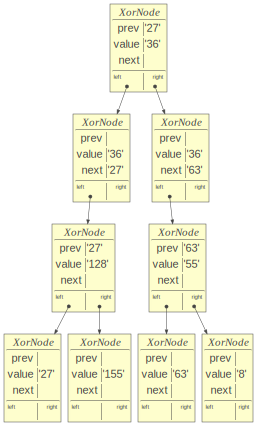

In [22]:
_data_bits  = data[0:8*8]
_data_bytes = list()
for _byte_id in range(0, 8):
    _start_bit       = _byte_id * 8
    _end_bit         = _start_bit + 8
    _data_byte_value = _data_bits[_start_bit:_end_bit]
    _data_bytes.append(_data_byte_value)
pprint(_data_bytes)

@dataclass()
class XorNode:
    def __init__(self, data: bitarray, left=None, right=None, prev=None, next=None):
        self.prev  = prev
        self.value = ba2int(data)
        self.left  = left
        self.right = right
        self.next  = next

xor_byte_0  = _data_bytes[0] ^ _data_bytes[1]
prev_byte_0 = _data_bytes[0].copy()
xor_node_0  = XorNode(data=xor_byte_0, left=XorNode(data=_data_bytes[0]), right=XorNode(_data_bytes[1]), prev=ba2int(prev_byte_0))

xor_byte_1  = _data_bytes[2] ^ _data_bytes[3]
prev_byte_1 = _data_bytes[2].copy()
xor_node_1  = XorNode(data=xor_byte_1, left=XorNode(data=_data_bytes[2]), right=XorNode(_data_bytes[3]), prev=ba2int(prev_byte_1))

xor_byte_2   = prev_byte_0 ^ prev_byte_1
prev_byte_2  = prev_byte_0.copy()

prev_node_0  = XorNode(data=xor_byte_2, left=xor_node_0, right=None, next=ba2int(prev_byte_0))
prev_node_1  = XorNode(data=xor_byte_2, left=xor_node_1, right=None, next=ba2int(prev_byte_1))

xor_node_2   = XorNode(data=xor_byte_2, left=prev_node_0, right=prev_node_1, next=None, prev=ba2int(prev_byte_2))

treeviz(xor_node_2)

In [14]:
class XorNibbleType(int, Enum):
    SEED    : int = 0
    POINTER : int = 1

    def __str__(self):
        return f'{self.name}({self.value})'
    
    def __repr__(self):
        return f'{self.name}({self.value})'

class XorPointerType(int, Enum):
    # '00' - both nibbles are final: 
    # from 0 to 2 bits hamming distance between seed byte and data byte
    DATA_POINTER       : int = 0
    # '01' - left nibble is final, right nibble is nested:
    LEFT_SEED_POINTER  : int = 1
    # '10' - left nibble is nested, right nibble is final:
    RIGHT_SEED_POINTER : int = 2
    # '11' - both nibbles are nested:
    EXPANSION_SEED     : int = 3

    def to_bitarray(self) -> bitarray:
        return int2ba(self.value, length=2, endian=DEFAULT_ENDIAN, signed=False)

    def __str__(self):
        return f'{self.name}({self.to_bitarray().to01()})'
    
    def __repr__(self):
        return f'{self.name}({self.to_bitarray().to01()})'
    
    def has_expansion(self, pointer_type: XorPointerType | None = None) -> bool:
        if (pointer_type is None):
            value = self.value
        else:
            value = pointer_type.value
        if (value in [0, 3]):
            return True
        if (value in [1, 2]):
            return False
        raise Exception(f"Unknown value={self.value}")

def get_left_nibble_type(pointer_bits: bitarray) -> XorNibbleType:
    return XorNibbleType(pointer_bits[0])

def get_right_nibble_type(pointer_bits: bitarray) -> XorNibbleType:
    return XorNibbleType(pointer_bits[4])

def get_left_nibble_bit_id(pointer_bits: bitarray) -> int:
    return ba2int(pointer_bits[1:4], signed=False)

def get_right_nibble_bit_id(pointer_bits: bitarray) -> int:
    return ba2int(pointer_bits[5:8], signed=False)

def get_pointer_bit_ids(pointer_bits: bitarray) -> List[int]:
    return [
        get_left_nibble_bit_id(pointer_bits=pointer_bits),
        get_right_nibble_bit_id(pointer_bits=pointer_bits),
    ]

def invert_value_bit(value_bits: bitarray, bit_id: int) -> bitarray:
    if (len(value_bits) != 8):
        raise Exception(f"Incorrect value_bits={value_bits.to01()} ({len(value_bits)}): length must be 8 bits")
    new_bits = value_bits.copy()
    new_bits.invert(bit_id)
    return new_bits

def invert_value_bits(value_bits: bitarray, bit_ids: List[int]) -> bitarray:
    if (len(value_bits) != 8):
        raise Exception(f"Incorrect value_bits={value_bits.to01()} ({len(value_bits)}): length must be 8 bits")
    new_bits = value_bits.copy()
    for bit_id in bit_ids:
        new_bits.invert(bit_id)
    return new_bits

def get_xor_pointer_type(pointer_bits: bitarray) -> PointerType:
    """
    Define type of byte pointer using types of its left and right nibble pointers
    """
    type_bits    = zeros(2, endian=DEFAULT_ENDIAN)
    type_bits[0] = pointer_bits[0]
    type_bits[1] = pointer_bits[4]
    type_value   = ba2int(type_bits, signed=False)
    return XorPointerType(type_value)

def resolve_xor_pointer(seed_byte: int, pointer_byte: int) -> Tuple[int, int] | Tuple[int]:
    seed_bits    = int2ba(seed_byte, length=8, endian=DEFAULT_ENDIAN, signed=False)
    pointer_bits = int2ba(pointer_byte, length=8, endian=DEFAULT_ENDIAN, signed=False)
    pointer_type = get_xor_pointer_type(pointer_bits=pointer_bits)
    

def resolve_xor_data_pointer(seed_bits: bitarray, pointer_bits: bitarray) -> Tuple[int]:
    bit_ids      = get_pointer_bit_ids(pointer_bits=pointer_bits)
    data_bits    = invert_value_bits(value_bits=seed_bits, bit_ids=bit_ids)
    return (ba2int(data_bits, signed=False), )

def resolve_xor_left_seed_pointer(seed_bits: bitarray, pointer_bits: bitarray) -> Tuple[int, int]:
    seed_bit_id       = get_left_nibble_bit_id(pointer_bits=pointer_bits)
    next_seed_bits    = invert_value_bit(value_bits=seed_bits, bit_id=seed_bit_id)
    pointer_bit_id    = get_right_nibble_bit_id(pointer_bits=pointer_bits)
    next_pointer_bits = invert_value_bit(value_bits=seed_bits, bit_id=pointer_bit_id)
    return (ba2int(next_seed_bits, signed=False), ba2int(next_pointer_bits, signed=False))

def resolve_xor_right_seed_pointer(seed_bits: bitarray, pointer_bits: bitarray) -> Tuple[int, int]:
    seed_bit_id       = get_right_nibble_bit_id(pointer_bits=pointer_bits)
    next_seed_bits    = invert_value_bit(value_bits=seed_bits, bit_id=seed_bit_id)
    pointer_bit_id    = get_left_nibble_bit_id(pointer_bits=pointer_bits)
    next_pointer_bits = invert_value_bit(value_bits=seed_bits, bit_id=pointer_bit_id)
    return (ba2int(next_seed_bits, signed=False), ba2int(next_pointer_bits, signed=False))




print(invert_value_bit(value_bits= bitarray('01111111'), bit_id=4))

bitarray('01110111')

In [20]:
distance_counts = defaultdict()
for byte_id in range(0, 256):
    byte_data = int2ba(byte_id, length=8, endian=DEFAULT_ENDIAN, signed=False)
    for next_byte_id in range(0, 256):
        next_byte_data = int2ba(next_byte_id, length=8, endian=DEFAULT_ENDIAN, signed=False)
        xor_byte_data  = byte_data ^ next_byte_data
        distance       = xor_byte_data.count(1)
        distance_counts[byte_id].update({ next_byte_id: distance })

[15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [38]:
hamming_code = [
    0x00,
    0x0F,
    0x33,
    0x3C,
    0x55,
    0x5A,
    0x66,
    0x69,
    0x96,
    0x99,
    0xA5,
    0xAA,
    0xC3,
    0xCC,
    0xF0,
    0xFF
]
print(hamming_code)
hc_bits = [int2ba(_v, length=8, endian=DEFAULT_ENDIAN, signed=False) for _v in hamming_code]
print(f"hc_bits:", hc_bits)

all_value_counts = Counter()
all_values       = SortedSet()
all_byte_values  = defaultdict(SortedSet)
for _byte_value in range(0, 256):
    byte_value_bits = int2ba(_byte_value, length=8, endian=DEFAULT_ENDIAN, signed=False)
    for hc_item in hc_bits[0:8]:
        byte_xor     = hc_item ^ byte_value_bits
        byte_xor_int = ba2int(byte_xor)
        all_value_counts.update({ byte_xor_int: 1 })
        all_values.add(byte_xor_int)
        all_byte_values[_byte_value].add(byte_xor_int)
    #byte_1 = hc_bits[i]
    #if (i > 0):
    #    byte_1 = byte_1 ^ prev_byte
    #print(f"{i}:", ba2int(byte_1), byte_1)
    #prev_byte = byte_1
    #for l in range(i, -1, -1):
    #    remaining_bytes = hc_bits[l+2:len(hc_bits)]
    #    remaining_xor   = None
    #    for remaining_byte in remaining_bytes:
    #        if (remaining_xor is None):
    #            remaining_xor = remaining_byte.copy()
    #            continue
    #        remaining_xor = remaining_xor ^ remaining_byte.copy()
    #    if (remaining_xor is None):
    #        continue
    #    byte_2       = remaining_xor #hc_bits[l].copy()
    #    xor_byte     = byte_1 ^ byte_2
    #    xor_byte_int = ba2int(xor_byte)
    #    all_values.add(xor_byte_int)
    #    print(xor_byte_int, xor_byte)

print(all_value_counts.first_items())
print(all_values)
print(all_byte_values)

[0, 15, 51, 60, 85, 90, 102, 105, 150, 153, 165, 170, 195, 204, 240, 255]

[
    bitarray('00000000'),
    bitarray('00001111'),
    bitarray('00110011'),
    bitarray('00111100'),
    bitarray('01010101'),
    bitarray('01011010'),
    bitarray('01100110'),
    bitarray('01101001'),
    bitarray('10010110'),
    bitarray('10011001'),
    bitarray('10100101'),
    bitarray('10101010'),
    bitarray('11000011'),
    bitarray('11001100'),
    bitarray('11110000'),
    bitarray('11111111')
]

[
    (0, 8),
    (1, 8),
    (2, 8),
    (3, 8),
    (4, 8),
    (5, 8),
    (6, 8),
    (7, 8),
    (8, 8),
    (9, 8),
    (10, 8),
    (11, 8),
    (12, 8),
    (13, 8),
    (14, 8),
    (15, 8),
    (16, 8),
    (17, 8),
    (18, 8),
    (19, 8),
    (20, 8),
    (21, 8),
    (22, 8),
    (23, 8),
    (24, 8),
    (25, 8),
    (26, 8),
    (27, 8),
    (28, 8),
    (29, 8),
    (30, 8),
    (31, 8),
    (32, 8),
    (33, 8),
    (34, 8),
    (35, 8),
    (36, 8),
    (37, 8),
    (38, 8),
    (39, 8),
    (40, 8),
    (41, 8),
    (42, 8),
    (43, 8),
    (44, 8),
    (45, 8),
    (46, 8),
    (47, 8),
    (48, 8),
    (49, 8),
    (50, 8),
    (51, 8),
    (52, 8),
    (53, 8),
    (54, 8),
    (55, 8),
    (56, 8),
    (57, 8),
    (58, 8),
    (59, 8),
    (60, 8),
    (61, 8),
    (62, 8),
    (63, 8),
    (64, 8),
    (65, 8),
    (66, 8),
    (67, 8),
    (68, 8),
    (69, 8),
    (70, 8),
    (71, 8),
    (72, 8),
    (73, 8),
    (74, 8),
    (75, 8),
    (76, 8),
    (77, 8),
    (78, 8),
    (79, 8),
    (80, 8),
    (81, 8),
    (82, 8),
    (83, 8),
    (84, 8),
    (85, 8),
    (86, 8),
    (87, 8),
    (88, 8),
    (89, 8),
    (90, 8),
    (91, 8),
    (92, 8),
    (93, 8),
    (94, 8),
    (95, 8),
    (96, 8),
    (97, 8),
    (98, 8),
    (99, 8),
    (100, 8),
    (101, 8),
    (102, 8),
    (103, 8),
    (104, 8),
    (105, 8),
    (106, 8),
    (107, 8),
    (108, 8),
    (109, 8),
    (110, 8),
    (111, 8),
    (112, 8),
    (113, 8),
    (114, 8),
    (115, 8),
    (116, 8),
    (117, 8),
    (118, 8),
    (119, 8),
    (120, 8),
    (121, 8),
    (122, 8),
    (123, 8),
    (124, 8),
    (125, 8),
    (126, 8),
    (127, 8),
    (128, 8),
    (129, 8),
    (130, 8),
    (131, 8),
    (132, 8),
    (133, 8),
    (134, 8),
    (135, 8),
    (136, 8),
    (137, 8),
    (138, 8),
    (139, 8),
    (140, 8),
    (141, 8),
    (142, 8),
    (143, 8),
    (144, 8),
    (145, 8),
    (146, 8),
    (147, 8),
    (148, 8),
    (149, 8),
    (150, 8),
    (151, 8),
    (152, 8),
    (153, 8),
    (154, 8),
    (155, 8),
    (156, 8),
    (157, 8),
    (158, 8),
    (159, 8),
    (160, 8),
    (161, 8),
    (162, 8),
    (163, 8),
    (164, 8),
    (165, 8),
    (166, 8),
    (167, 8),
    (168, 8),
    (169, 8),
    (170, 8),
    (171, 8),
    (172, 8),
    (173, 8),
    (174, 8),
    (175, 8),
    (176, 8),
    (177, 8),
    (178, 8),
    (179, 8),
    (180, 8),
    (181, 8),
    (182, 8),
    (183, 8),
    (184, 8),
    (185, 8),
    (186, 8),
    (187, 8),
    (188, 8),
    (189, 8),
    (190, 8),
    (191, 8),
    (192, 8),
    (193, 8),
    (194, 8),
    (195, 8),
    (196, 8),
    (197, 8),
    (198, 8),
    (199, 8),
    (200, 8),
    (201, 8),
    (202, 8),
    (203, 8),
    (204, 8),
    (205, 8),
    (206, 8),
    (207, 8),
    (208, 8),
    (209, 8),
    (210, 8),
    (211, 8),
    (212, 8),
    (213, 8),
    (214, 8),
    (215, 8),
    (216, 8),
    (217, 8),
    (218, 8),
    (219, 8),
    (220, 8),
    (221, 8),
    (222, 8),
    (223, 8),
    (224, 8),
    (225, 8),
    (226, 8),
    (227, 8),
    (228, 8),
    (229, 8),
    (230, 8),
    (231, 8),
    (232, 8),
    (233, 8),
    (234, 8),
    (235, 8),
    (236, 8),
    (237, 8),
    (238, 8),
    (239, 8),
    (240, 8),
    (241, 8),
    (242, 8),
    (243, 8),
    (244, 8),
    (245, 8),
    (246, 8),
    (247, 8),
    (248, 8),
    (249, 8),
    (250, 8),
    (251, 8),
    (252, 8),
    (253, 8),
    (254, 8),
    (255, 8)
]

SortedSet([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 
135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 
158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 
181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 
204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 
227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 
250, 251, 252, 253, 254, 255])

defaultdict(<class 'sortedcontainers.sortedset.SortedSet'>, {
    0: SortedSet([0, 15, 51, 60, 85, 90, 102, 105]),
    1: SortedSet([1, 14, 50, 61, 84, 91, 103, 104]),
    2: SortedSet([2, 13, 49, 62, 87, 88, 100, 107]),
    3: SortedSet([3, 12, 48, 63, 86, 89, 101, 106]),
    4: SortedSet([4, 11, 55, 56, 81, 94, 98, 109]),
    5: SortedSet([5, 10, 54, 57, 80, 95, 99, 108]),
    6: SortedSet([6, 9, 53, 58, 83, 92, 96, 111]),
    7: SortedSet([7, 8, 52, 59, 82, 93, 97, 110]),
    8: SortedSet([7, 8, 52, 59, 82, 93, 97, 110]),
    9: SortedSet([6, 9, 53, 58, 83, 92, 96, 111]),
    10: SortedSet([5, 10, 54, 57, 80, 95, 99, 108]),
    11: SortedSet([4, 11, 55, 56, 81, 94, 98, 109]),
    12: SortedSet([3, 12, 48, 63, 86, 89, 101, 106]),
    13: SortedSet([2, 13, 49, 62, 87, 88, 100, 107]),
    14: SortedSet([1, 14, 50, 61, 84, 91, 103, 104]),
    15: SortedSet([0, 15, 51, 60, 85, 90, 102, 105]),
    16: SortedSet([16, 31, 35, 44, 69, 74, 118, 121]),
    17: SortedSet([17, 30, 34, 45, 68, 75, 119, 120]),
    18: SortedSet([18, 29, 33, 46, 71, 72, 116, 123]),
    19: SortedSet([19, 28, 32, 47, 70, 73, 117, 122]),
    20: SortedSet([20, 27, 39, 40, 65, 78, 114, 125]),
    21: SortedSet([21, 26, 38, 41, 64, 79, 115, 124]),
    22: SortedSet([22, 25, 37, 42, 67, 76, 112, 127]),
    23: SortedSet([23, 24, 36, 43, 66, 77, 113, 126]),
    24: SortedSet([23, 24, 36, 43, 66, 77, 113, 126]),
    25: SortedSet([22, 25, 37, 42, 67, 76, 112, 127]),
    26: SortedSet([21, 26, 38, 41, 64, 79, 115, 124]),
    27: SortedSet([20, 27, 39, 40, 65, 78, 114, 125]),
    28: SortedSet([19, 28, 32, 47, 70, 73, 117, 122]),
    29: SortedSet([18, 29, 33, 46, 71, 72, 116, 123]),
    30: SortedSet([17, 30, 34, 45, 68, 75, 119, 120]),
    31: SortedSet([16, 31, 35, 44, 69, 74, 118, 121]),
    32: SortedSet([19, 28, 32, 47, 70, 73, 117, 122]),
    33: SortedSet([18, 29, 33, 46, 71, 72, 116, 123]),
    34: SortedSet([17, 30, 34, 45, 68, 75, 119, 120]),
    35: SortedSet([16, 31, 35, 44, 69, 74, 118, 121]),
    36: SortedSet([23, 24, 36, 43, 66, 77, 113, 126]),
    37: SortedSet([22, 25, 37, 42, 67, 76, 112, 127]),
    38: SortedSet([21, 26, 38, 41, 64, 79, 115, 124]),
    39: SortedSet([20, 27, 39, 40, 65, 78, 114, 125]),
    40: SortedSet([20, 27, 39, 40, 65, 78, 114, 125]),
    41: SortedSet([21, 26, 38, 41, 64, 79, 115, 124]),
    42: SortedSet([22, 25, 37, 42, 67, 76, 112, 127]),
    43: SortedSet([23, 24, 36, 43, 66, 77, 113, 126]),
    44: SortedSet([16, 31, 35, 44, 69, 74, 118, 121]),
    45: SortedSet([17, 30, 34, 45, 68, 75, 119, 120]),
    46: SortedSet([18, 29, 33, 46, 71, 72, 116, 123]),
    47: SortedSet([19, 28, 32, 47, 70, 73, 117, 122]),
    48: SortedSet([3, 12, 48, 63, 86, 89, 101, 106]),
    49: SortedSet([2, 13, 49, 62, 87, 88, 100, 107]),
    50: SortedSet([1, 14, 50, 61, 84, 91, 103, 104]),
    51: SortedSet([0, 15, 51, 60, 85, 90, 102, 105]),
    52: SortedSet([7, 8, 52, 59, 82, 93, 97, 110]),
    53: SortedSet([6, 9, 53, 58, 83, 92, 96, 111]),
    54: SortedSet([5, 10, 54, 57, 80, 95, 99, 108]),
    55: SortedSet([4, 11, 55, 56, 81, 94, 98, 109]),
    56: SortedSet([4, 11, 55, 56, 81, 94, 98, 109]),
    57: SortedSet([5, 10, 54, 57, 80, 95, 99, 108]),
    58: SortedSet([6, 9, 53, 58, 83, 92, 96, 111]),
    59: SortedSet([7, 8, 52, 59, 82, 93, 97, 110]),
    60: SortedSet([0, 15, 51, 60, 85, 90, 102, 105]),
    61: SortedSet([1, 14, 50, 61, 84, 91, 103, 104]),
    62: SortedSet([2, 13, 49, 62, 87, 88, 100, 107]),
    63: SortedSet([3, 12, 48, 63, 86, 89, 101, 106]),
    64: SortedSet([21, 26, 38, 41, 64, 79, 115, 124]),
    65: SortedSet([20, 27, 39, 40, 65, 78, 114, 125]),
    66: SortedSet([23, 24, 36, 43, 66, 77, 113, 126]),
    67: SortedSet([22, 25, 37, 42, 67, 76, 112, 127]),
    68: SortedSet([17, 30, 34, 45, 68, 75, 119, 120]),
    69: SortedSet([16, 31, 35, 44, 69, 74, 118, 121]),
    70: SortedSet([19, 28, 32, 47, 70, 73, 117, 122]),
    71: SortedSet([18, 29, 33, 46, 71, 72, 116, 123]),
    72: SortedSet([18, 29, 33, 46, 71, 72, 1

In [ ]:
@dataclass()
class XorNode:
    data    : bitarray = field()
    left    : XorNode  = field()
    right   : XorNode  = field()
    value   : int      = field(init=False, default=None)
    level   : int      = field(default=None)
    parent  : int      = field(default=None)

    def __init__(self, seed: int, data: bitarray):
        if (len(data) != 8):
            raise Exception(f"Incorrect data={data.to01()} ({len(data)}): length must be 8 bits")
        self.seed    = seed
        self.data    = data.copy()

def init_xor_tree(data_bytes: List[bitarray]):
    pass

In [28]:
actual_values  = [2, 3, 1, 4, 6, 7]
min_value      = min(actual_values) 
max_value      = min_value + len(actual_values) 
desired_values = range(min_value, max_value + 1) 

missing = 0 
for x in actual_values: 
    missing ^= x 
for x in desired_values: 
    missing ^= x 
print(missing)



5